<a href="https://colab.research.google.com/github/whyd-nrzlvn/banana_classification/blob/main/models/Original__ES__DenseNet201_Classification_Cavendish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bagian Baru

## Import Dataset

In [ ]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Packages



In [ ]:
# import packages
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Conv2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

## Generate Dataset


In [ ]:
# directory dataset training dan validation
dir = '/content/drive/MyDrive/Skripsi/DataPisang1000'

# image size
img_width, img_height, channel = (224, 224, 3)

# **Melakukan Data Generator**

**Data Generator pada train dataset**

In [ ]:
# melakukan Data Generator pada train dataset
datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    validation_split = 0.20,
)

train_data = datagen.flow_from_directory(
    dir,
    target_size = (img_width, img_height),
    batch_size = 32,
    shuffle=True,
    subset='training',
    class_mode = 'categorical'
)

valid_data = datagen.flow_from_directory(
    dir,
    target_size = (img_width, img_height),
    batch_size = 32,
    shuffle=False,
    subset='validation',
    class_mode = 'categorical'
)

Found 800 images belonging to 3 classes.


**Menyimpan Hasil Data Generator**

In [ ]:
from PIL import Image #nb
import os
import shutil

#Menyimpan gambar ke Google Drive
def save_to_drive(image_path, folder_path):
    # Copy gambar ke Google Drive
    shutil.copy(image_path, folder_path)

#Menyimpan 60 gambar hasil dari valid_data ke Google Drive, bisa di atur sesuai keinginan
i = 0
for batch, labels in train_data:
    images_per_class = {}  # Dictionary untuk melacak jumlah gambar yang disimpan dalam setiap kelas

    for idx, (img, label) in enumerate(zip(batch, labels)):
        if i >= 60:  # Menyimpan hanya 60 gambar
            break  # Berhenti jika sudah menyimpan sebanyak yang diinginkan

        # Mendapatkan label kelas
        class_index = label.argmax()

        # Membuat nama folder berdasarkan label kelas
        folder_name = f'{class_index}'

        # Path folder sesuai dengan kelas
        folder_path = os.path.join('/content/drive/MyDrive/Skripsi/dataImage', folder_name)

        # Jika folder belum ada, buat folder baru
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # Nama file untuk disimpan secara sementara
        image_path = f'/content/augmented_image_{i}.jpg'

        # Simpan gambar dalam format JPEG
        Image.fromarray((img * 255).astype(np.uint8)).save(image_path)

        # Menyimpan gambar ke folder yang sesuai dengan kelasnya
        save_to_drive(image_path, folder_path)

        # Hapus gambar sementara setelah diunggah
        os.remove(image_path)

        # Menambahkan jumlah gambar yang disimpan dalam kelas ini
        images_per_class[class_index] = images_per_class.get(class_index, 0) + 1

        i += 1

    # Memeriksa apakah setiap folder kelas berisi tepat 20 gambar
    if all(images == 20 for images in images_per_class.values()):
        break  # Berhenti jika setiap folder kelas sudah berisi 20 gambar


In [ ]:
classes = train_data.class_indices
classes

{'busuk': 0, 'masak': 1, 'mentah': 2}

**Membuat Model**

In [ ]:
from tensorflow.keras.applications import DenseNet201, MobileNet, InceptionV3

base_model = DenseNet201(
    input_shape=(img_width, img_height, 3),
    include_top=True,
    weights='imagenet'
)

for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

82524592/82524592 [==============================] - 1s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormali

**Modifikasi Pre trained model**

In [ ]:
x = base_model.layers[-2].output
output = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

## Compile Model

In [ ]:
# membuat compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics= [Recall(), Precision(), "accuracy"]
)

## Membuat Callback

In [ ]:
# membuat callback
model_callback = EarlyStopping(
    monitor = 'accuracy',
    verbose = 1,
    mode = 'max',
    patience = 10
)

## Membuat Fit Model

In [ ]:
# membuat fit model
history = model.fit(
    train_data,
    validation_data = valid_data,
    epochs = 50,
    steps_per_epoch = 25,
    callbacks = [model_callback],
    verbose = 1
)

Epoch 1/50
25/25 [==============================] - 300s 11s/step - loss: 0.9346 - recall: 0.3963 - precision: 0.6443 - accuracy: 0.5537 - val_loss: 0.5456 - val_recall: 0.6950 - val_precision: 0.8424 - val_accuracy: 0.8100
Epoch 2/50
25/25 [==============================] - 72s 3s/step - loss: 0.4451 - recall: 0.7875 - precision: 0.8898 - accuracy: 0.8525 - val_loss: 0.3350 - val_recall: 0.8850 - val_precision: 0.9415 - val_accuracy: 0.9150
Epoch 3/50
25/25 [==============================] - 87s 4s/step - loss: 0.3039 - recall: 0.9187 - precision: 0.9472 - accuracy: 0.9362 - val_loss: 0.2600 - val_recall: 0.9000 - val_precision: 0.9574 - val_accuracy: 0.9250
Epoch 4/50
25/25 [==============================] - 77s 3s/step - loss: 0.2419 - recall: 0.9400 - precision: 0.9580 - accuracy: 0.9500 - val_loss: 0.2347 - val_recall: 0.9050 - val_precision: 0.9526 - val_accuracy: 0.9250
Epoch 5/50
25/25 [==============================] - 83s 3s/step - loss: 0.2021 - recall: 0.9425 - precision: 0

## Evaluasi

In [ ]:
# evaluasi hasil model kalian disini
model.evaluate(valid_data)

7/7 [==============================] - 12s 2s/step - loss: 0.0493 - recall: 0.9850 - precision: 0.9850 - accuracy: 0.9850


[0.049269724637269974,
 0.9850000143051147,
 0.9850000143051147,
 0.9850000143051147]

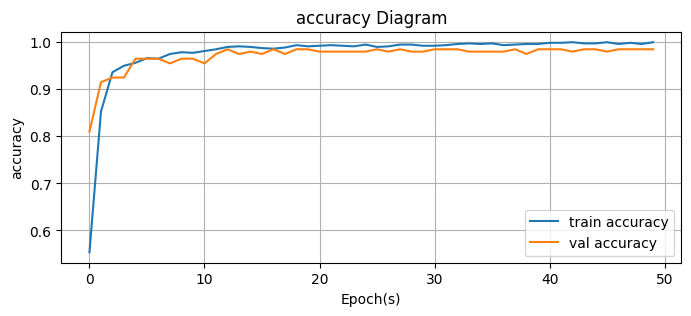

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(history.epoch, history.history['accuracy'])
plt.plot(history.epoch, history.history['val_accuracy'])
plt.legend(['train accuracy', 'val accuracy'])
plt.title('accuracy Diagram')
plt.xlabel('Epoch(s)')
plt.ylabel('accuracy')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
labels

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Skripsi/model/myModel2(original_es_mobilenet).h5')

In [ ]:
y_test = valid_data.classes
y_pred = model.predict(valid_data)
y_pred_probs = y_pred.copy()

In [ ]:
y_test

In [ ]:
y_pred_int = np.argmax(y_pred_probs, axis=1)

In [ ]:
print(classification_report(y_test,y_pred_int,target_names = labels))

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred_int),annot=True,fmt='.3g',xticklabels=labels,
            yticklabels=labels,cmap='Blues')
plt.show()

# Simpan Model

In [ ]:
# save model
model.save('/content/drive/MyDrive/Skripsi/model/myModel2(original_es_densenet201).h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

path_model_save = '/content/drive/MyDrive/Skripsi/model/myModel(original_es_mobilenet).h5'
loaded_model = load_model(path_model_save)

## Load Model dan Jalankan Model

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  img_path = '/content/' + fn
  img = image.load_img(img_path, target_size=(224, 224));
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  classes = loaded_model.predict(img_array/255);

  for i, class_ in enumerate(classes[0]):
      if class_ == classes[0].max():
          if i == 0:
              print("Pisang Busuk")
          elif i == 1:
              print("Pisang Masak")
          else:
              print("Pisang Mentah")

Saving download.jPG to download.jPG
1/1 [==============================] - 0s 26ms/step
Pisang Mentah
